In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from numpy.random import default_rng
from pytensor import tensor as pt
from scipy.special import expit as invlogit

In [2]:
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter(action="ignore", category=(FutureWarning, UserWarning))
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)
rng = default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89

In [3]:
def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

#### Code 15.1

In [4]:
# Simulate a pancake and return randomly ordered sides
def sim_pancake():
    pancake = rng.integers(3)
    sides = np.array([[1, 1], [1, 0], [0, 0]])[pancake]
    return rng.permutation(sides)


# Simulate 10,000 pancakes
pancakes = np.array([sim_pancake() for i in range(10000)])
up = pancakes[:, 0]
down = pancakes[:, 1]

# Compute proportion 1/1 (BB) out of all 1/1 and 1/0
num_11_10 = np.sum(up == 1)
num_11 = np.sum((up == 1) & (down == 1))
print(f"P(burnt down | burnt up) = {round(num_11 / num_11_10, 2)}")

P(burnt down | burnt up) = 0.66


#### Code 15.2

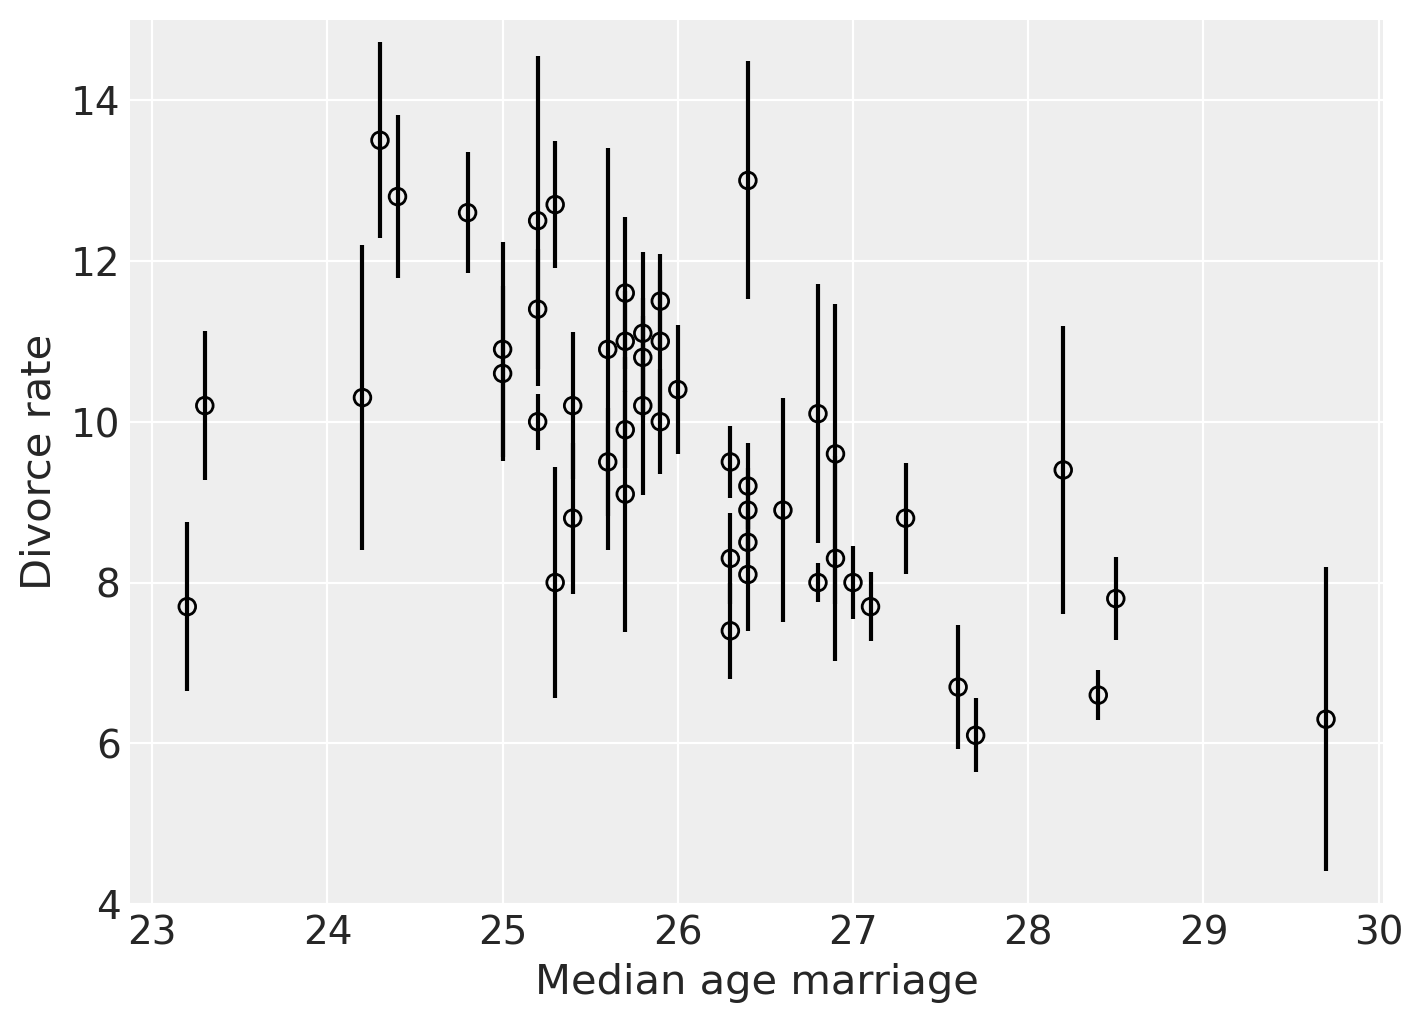

In [5]:
d = pd.read_csv("Data/WaffleDivorce.csv", sep=";")

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(d["MedianAgeMarriage"], d["Divorce"], edgecolor="k", facecolor="none")
ax.errorbar(d["MedianAgeMarriage"], d["Divorce"], yerr=d["Divorce SE"], fmt="none", c="k")

ax.set_ylim(4, 15)
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate");

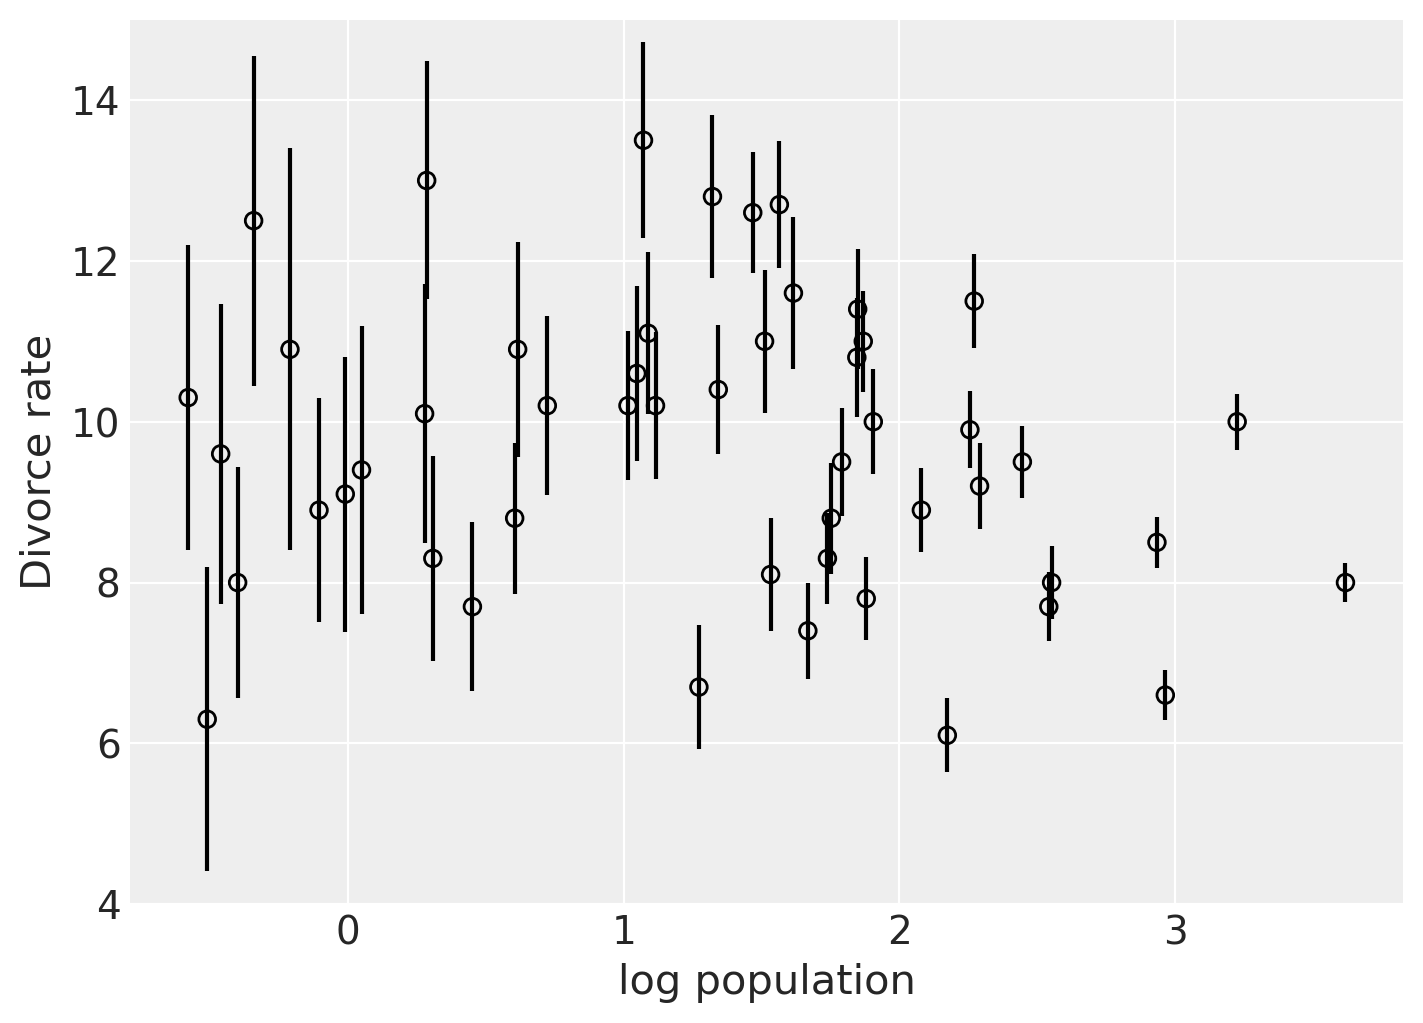

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(np.log(d["Population"]), d["Divorce"], edgecolor="k", facecolor="none")
ax.errorbar(np.log(d["Population"]), d["Divorce"], yerr=d["Divorce SE"], fmt="none", c="k")

ax.set_ylim(4, 15)
ax.set_xlabel("log population")
ax.set_ylabel("Divorce rate");

#### Code 15.3

In [7]:
D_obs = standardize(d["Divorce"].values)
D_sd = d["Divorce SE"].values / d["Divorce"].std()
M = standardize(d["Marriage"].values)
A = standardize(d["MedianAgeMarriage"].values)
N = len(d)

with pm.Model() as m15_1:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = a + bA * A + bM * M  # linear model to assess A -> D
    D_true = pm.Normal("D_true", mu, sigma, shape=N)  # distribution for true values

    D = pm.Normal("D_obs", D_true, D_sd, observed=D_obs)  # distribution for observed values

    idata_m15_1 = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a, D_true]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 114 seconds.
There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


#### Code 15.4

In [8]:
az.summary(idata_m15_1, var_names=["~D_true"], round_to=2)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,0.05,0.17,-0.20,0.33,0.0,0.0,1225.43,873.02,1.00
bA,-0.62,0.16,-0.87,-0.37,0.0,0.0,2001.46,2937.40,1.00
a,-0.05,0.09,-0.20,0.10,0.0,0.0,2630.96,3148.15,1.00
sigma,0.60,0.11,0.43,0.77,0.0,0.0,726.65,365.16,1.01


#### Code 15.5

In [9]:
D_obs = standardize(d["Divorce"].values)
D_sd = d["Divorce SE"].values / d["Divorce"].std()
M_obs = standardize(d["Marriage"].values)
M_sd = d["Marriage SE"].values / d["Marriage"].std()
A = standardize(d["MedianAgeMarriage"].values)
N = len(d)

with pm.Model() as m15_2:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    bA = pm.Normal("bA", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    M_true = pm.Normal("M_true", 0, 1, shape=N)  # distribution for true M values
    mu = a + bA * A + bM * M_true  # linear model
    D_true = pm.Normal("D_true", mu, sigma, shape=N)  # distribution for true D values

    D = pm.Normal("D_obs", D_true, D_sd, observed=D_obs)  # distribution for observed D values
    M = pm.Normal("M_obs", M_true, M_sd, observed=M_obs)  # distribution for observed M values

    idata_m15_2 = pm.sample(random_seed=RANDOM_SEED)

az.summary(idata_m15_2, var_names=["~D_true", "~M_true"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, bA, a, M_true, D_true]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 101 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,0.20,0.21,-0.14,0.51,0.0,0.0,2270.35,2934.23,1.0
bA,-0.54,0.16,-0.80,-0.28,0.0,0.0,3284.57,3264.06,1.0
a,-0.04,0.10,-0.19,0.11,0.0,0.0,4706.57,3129.04,1.0
sigma,0.57,0.11,0.40,0.74,0.0,0.0,1506.34,1755.51,1.0


#### Code 15.6

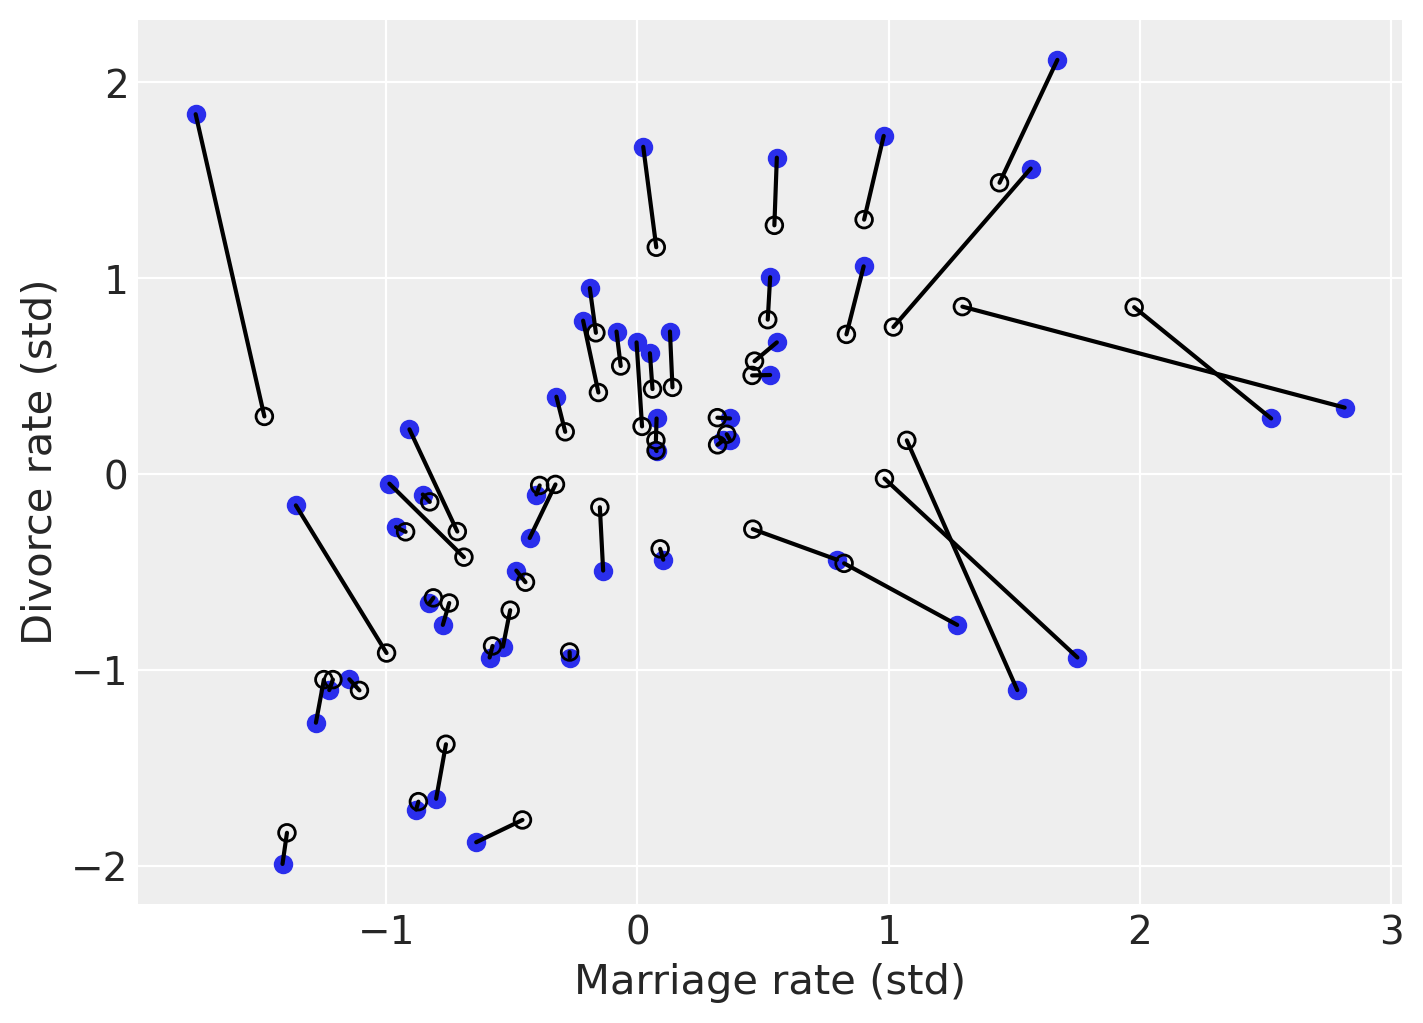

In [10]:
D_true = idata_m15_2.posterior["D_true"].mean(dim=["chain", "draw"])
M_true = idata_m15_2.posterior["M_true"].mean(dim=["chain", "draw"])

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(M_obs, D_obs)
ax.scatter(M_true, D_true, edgecolor="k", facecolor="none")
ax.plot([M_obs, M_true], [D_obs, D_true], c="k")

ax.set_xlabel("Marriage rate (std)")
ax.set_ylabel("Divorce rate (std)");

#### Code 15.11

In [11]:
N = 1000  # Number of students
X = rng.normal(size=N)  # Noise of house (unobserved)
S = rng.normal(size=N)  # How much each student studies
H = rng.binomial(
    n=10, p=invlogit(2 + S - 2 * X), size=N
)  # Homework grade affected by study and noise
D = X > 1  # Dogs eat homework in noisy houses

#### Code 15.12

In [12]:
# Model complete dataset

with pm.Model() as m15_3:
    bS = pm.Normal("bS", 0, 0.5)
    a = pm.Normal("a", 0, 1)

    p = pm.invlogit(a + bS * S)  # Model includes study S but not noise X

    Hi = pm.Binomial("Hi", n=10, p=p, observed=H)

    idata_m15_3 = pm.sample(random_seed=RANDOM_SEED)

# The estimate for bS is biased by the unobserved confound X
az.summary(idata_m15_3, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bS, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 87 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bS,0.62,0.03,0.58,0.67,0.0,0.0,3791.09,2801.99,1.0
a,1.25,0.03,1.21,1.29,0.0,0.0,3859.69,3243.56,1.0


#### Code 15.13

In [13]:
# Model only non-missing data - dogs ate some homework

H_star = H[D == 0]
S_star = S[D == 0]

with pm.Model() as m15_4:
    bS = pm.Normal("bS", 0, 0.5)
    a = pm.Normal("a", 0, 1)

    p = pm.invlogit(a + bS * S_star)

    Hi = pm.Binomial("Hi", n=10, p=p, observed=H_star)

    idata_m15_4 = pm.sample(random_seed=RANDOM_SEED)

# In this case the estimate for bS is a bit closer to the true value of 1
az.summary(idata_m15_4, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bS, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bS,0.77,0.03,0.71,0.82,0.0,0.0,3276.80,3166.55,1.0
a,1.85,0.03,1.79,1.90,0.0,0.0,3388.13,3111.36,1.0


#### Code 15.16

In [14]:
d = pd.read_csv("Data/milk.csv", sep=";")
d["neocortex.prop"] = d["neocortex.perc"] / 100
d["logmass"] = np.log(d["mass"])

K = standardize(d["kcal.per.g"]).values
B = standardize(d["neocortex.prop"]).values
M = standardize(d["logmass"]).values

print(f"Number of missing values in B = {np.sum(np.isnan(B))}")

Number of missing values in B = 12


#### Code 15.17

In [15]:
# Impute missing values of B

with pm.Model() as m15_5:
    sigma_B = pm.Exponential("sigma_B", 1)
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    bB = pm.Normal("bB", 0, 0.5)
    nu = pm.Normal("nu", 0, 0.5)
    a = pm.Normal("a", 0, 0.5)

    # PyMC automatically imputes missing values
    Bi = pm.Normal("Bi", nu, sigma_B, observed=B)

    mu = a + bB * Bi + bM * M

    Ki = pm.Normal("Ki", mu, sigma, observed=K)

    idata_m15_5 = pm.sample(random_seed=RANDOM_SEED)
az.summary(idata_m15_5, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_B, sigma, bM, bB, nu, a, Bi_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 127 seconds.
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arv

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,-0.54,0.20,-0.86,-0.22,0.00,0.00,2146.75,2620.54,1.0
bB,0.49,0.24,0.12,0.87,0.01,0.00,1605.01,2440.80,1.0
nu,-0.04,0.21,-0.38,0.28,0.00,0.00,4074.47,3059.33,1.0
a,0.03,0.16,-0.22,0.29,0.00,0.00,4507.79,3140.55,1.0
Bi_unobserved[0],-0.57,0.92,-2.03,0.86,0.01,0.01,4736.39,3004.40,1.0
Bi_unobserved[1],-0.68,0.95,-2.32,0.68,0.01,0.01,4282.29,3080.30,1.0
Bi_unobserved[2],-0.69,0.95,-2.15,0.83,0.02,0.01,3693.71,2898.27,1.0
Bi_unobserved[3],-0.30,0.89,-1.66,1.16,0.01,0.01,5514.18,2941.41,1.0
Bi_unobserved[4],0.48,0.89,-0.87,1.98,0.01,0.01,4862.11,2957.58,1.0
Bi_unobserved[5],-0.17,0.90,-1.55,1.25,0.01,0.01,4480.88,2716.96,1.0


#### Code 15.19

In [16]:
# Model only complete cases for comparison with model 15_5

obs_idx = ~d["neocortex.prop"].isna()
K_obs = K[obs_idx]
B_obs = B[obs_idx]
M_obs = M[obs_idx]

with pm.Model() as m15_6:
    sigma_B = pm.Exponential("sigma_B", 1)
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    bB = pm.Normal("bB", 0, 0.5)
    nu = pm.Normal("nu", 0, 0.5)
    a = pm.Normal("a", 0, 0.5)

    Bi = pm.Normal("Bi", nu, sigma_B, observed=B_obs)

    mu = a + bB * Bi + bM * M_obs

    Ki = pm.Normal("Ki", mu, sigma, observed=K_obs)

    idata_m15_6 = pm.sample(random_seed=RANDOM_SEED)
az.summary(idata_m15_6, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_B, sigma, bM, bB, nu, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,-0.64,0.25,-1.05,-0.25,0.00,0.0,2968.95,2432.93,1.0
bB,0.60,0.28,0.18,1.06,0.01,0.0,3206.95,2152.18,1.0
nu,-0.00,0.23,-0.34,0.37,0.00,0.0,4079.09,2668.84,1.0
a,0.10,0.20,-0.23,0.40,0.00,0.0,4672.85,2753.01,1.0
sigma_B,1.04,0.19,0.74,1.31,0.00,0.0,4118.10,2825.65,1.0
sigma,0.88,0.18,0.59,1.12,0.00,0.0,3056.57,2523.01,1.0


#### Code 15.20

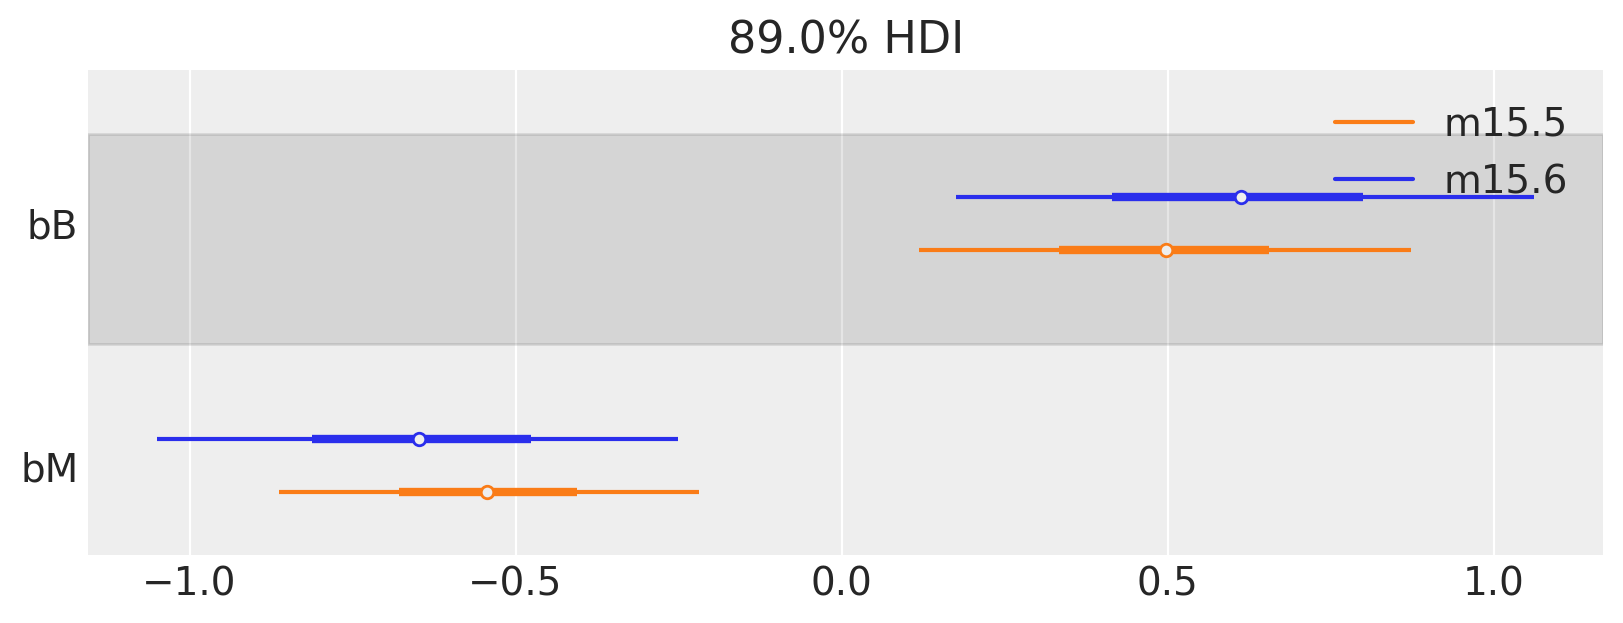

In [17]:
# Model m15.5 (which imputes the missing values) has narrower marginal distributions of bB and bM

az.plot_forest(
    [idata_m15_6, idata_m15_5],
    model_names=["m15.6", "m15.5"],
    var_names=["bB", "bM"],
    combined=True,
    figsize=(8, 3),
);

#### Code 15.21

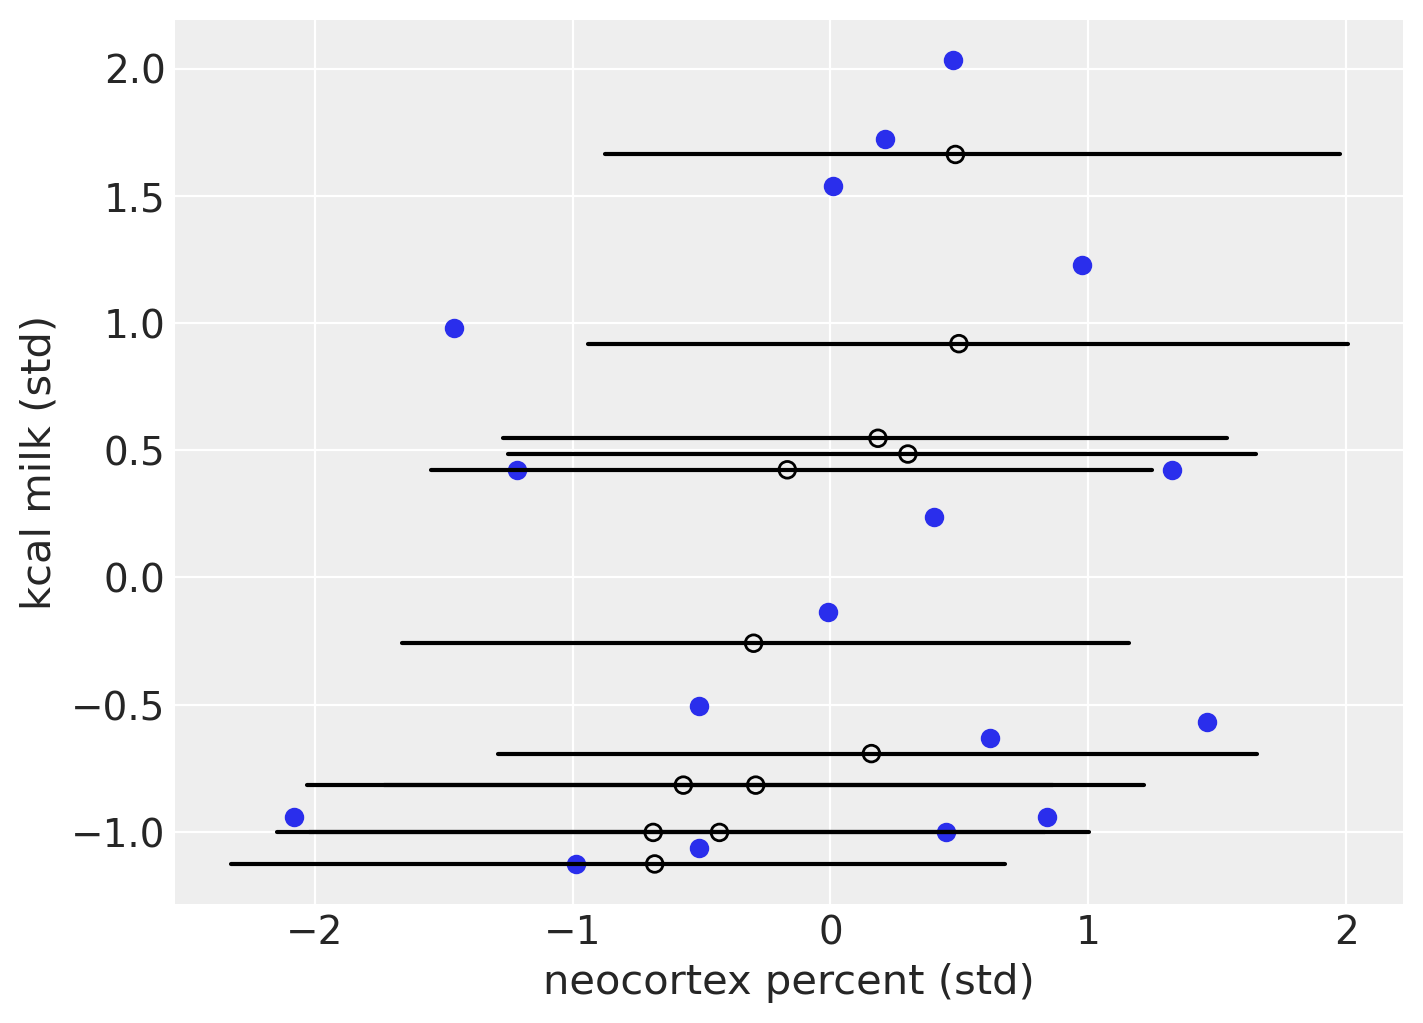

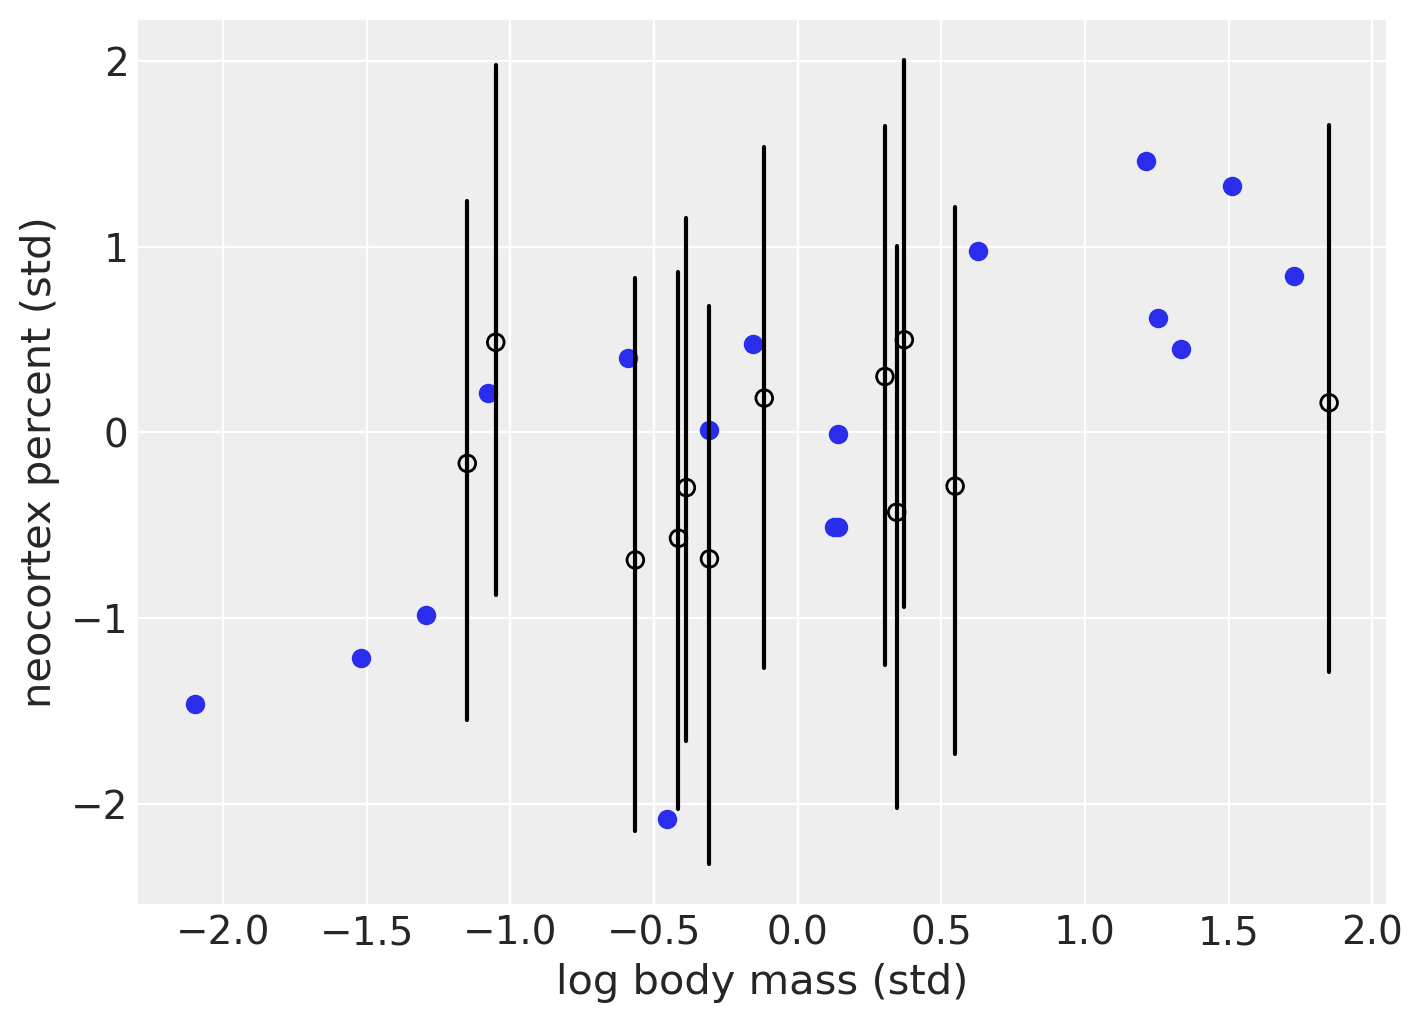

In [18]:
post = idata_m15_5["posterior"]

# Calculate the posterior mean and hdi for imputed values of B
B_impute_mu = post["Bi_unobserved"].mean(dim=["chain", "draw"])
B_impute_ci = az.hdi(post, var_names=["Bi_unobserved"])["Bi_unobserved"]

# B vs K
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(B, K)
ax.scatter(B_impute_mu, K[~obs_idx], edgecolor="k", facecolor="none")
ax.plot(
    [B_impute_ci.sel(hdi="lower"), B_impute_ci.sel(hdi="higher")],
    [K[~obs_idx], K[~obs_idx]],
    color="k",
)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kcal milk (std)")

# M vs B
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(M, B)
ax.scatter(M[~obs_idx], B_impute_mu, edgecolor="k", facecolor="none")
ax.plot(
    [M[~obs_idx], M[~obs_idx]],
    [B_impute_ci.sel(hdi="lower"), B_impute_ci.sel(hdi="higher")],
    color="k",
)
ax.set_xlabel("log body mass (std)")
ax.set_ylabel("neocortex percent (std)");

#### Code 15.22

In [19]:
# Include association between M and B

MB_masked = np.ma.masked_invalid(np.stack([M, B]).T)
MB_vals = np.stack([M, B], axis=1)

with pm.Model() as m15_7:
    sigma = pm.Exponential("sigma", 1)
    muM = pm.Normal("muM", 0, 0.5)
    muB = pm.Normal("muB", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    bB = pm.Normal("bB", 0, 0.5)
    a = pm.Normal("a", 0, 0.5)

    chol, _, _ = pm.LKJCholeskyCov(
        "chol_cov", n=2, eta=2, sd_dist=pm.Exponential.dist(1), compute_corr=True
    )

    # Create a vector of flat variables for the unobserved components of the MvNormal
    MB_impute = pm.Flat("MB_impute", shape=(np.isnan(MB_vals).sum(),))

    # Create the symbolic value of MB, combining observed data and unobserved variables
    MB = pt.as_tensor(MB_vals)

    MB = pm.Deterministic("MB", pt.set_subtensor(MB[np.isnan(MB_vals)], MB_impute))

    # Add a Potential with the logp of the variable conditioned on `MB`
    pm.Potential(
        "MB_logp", pm.logp(value=MB, rv=pm.MvNormal.dist(mu=pt.stack([muM, muB]), chol=chol))
    )
    mu = a + bB * MB[:, 1] + bM * M
    Ki = pm.Normal("Ki", mu, sigma, observed=K)

    idata_m15_7 = pm.sample(random_seed=RANDOM_SEED)
    idata_m15_7.rename({"chol_cov_corr": "Rho_MB"}, inplace=True)

# Strong correlation between M and B
az.summary(idata_m15_7, var_names=["bM", "bB", "Rho_MB"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, muM, muB, bM, bB, a, chol_cov, MB_impute]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 136 seconds.
c:\Users\mason\AppData\Local\Continuum\anaconda3\envs\stat-rethink2-pymc\Lib\site-packages\arviz\stats\diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,-0.64,0.22,-0.97,-0.28,0.00,0.0,2335.44,3141.15,1.0
bB,0.58,0.25,0.19,0.99,0.01,0.0,2125.65,3051.35,1.0
"Rho_MB[0, 0]",1.00,0.00,1.00,1.00,0.00,0.0,4000.00,4000.00,NaN
"Rho_MB[0, 1]",0.60,0.14,0.40,0.82,0.00,0.0,2998.58,2723.64,1.0
"Rho_MB[1, 0]",0.60,0.14,0.40,0.82,0.00,0.0,2998.58,2723.64,1.0
"Rho_MB[1, 1]",1.00,0.00,1.00,1.00,0.00,0.0,4037.24,3873.05,1.0


In [20]:
idata_m15_7.posterior

<xarray.Dataset>
Dimensions:              (chain: 4, draw: 1000, MB_impute_dim_0: 12,
                          chol_cov_dim_0: 3, chol_cov_corr_dim_0: 2,
                          chol_cov_corr_dim_1: 2, chol_cov_stds_dim_0: 2,
                          MB_dim_0: 29, MB_dim_1: 2)
Coordinates:
  * chain                (chain) int32 0 1 2 3
  * draw                 (draw) int32 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * MB_impute_dim_0      (MB_impute_dim_0) int32 0 1 2 3 4 5 6 7 8 9 10 11
  * chol_cov_dim_0       (chol_cov_dim_0) int32 0 1 2
  * chol_cov_corr_dim_0  (chol_cov_corr_dim_0) int32 0 1
  * chol_cov_corr_dim_1  (chol_cov_corr_dim_1) int32 0 1
  * chol_cov_stds_dim_0  (chol_cov_stds_dim_0) int32 0 1
  * MB_dim_0             (MB_dim_0) int32 0 1 2 3 4 5 6 ... 22 23 24 25 26 27 28
  * MB_dim_1             (MB_dim_1) int32 0 1
Data variables:
    muM                  (chain, draw) float64 -0.06641 0.09692 ... 0.1122
    muB                  (chain, draw) float64 -0.4085 -0.4136 ... -0.008622
    bM                   (chain, draw) float64 -0.6497 -0.5923 ... -0.8531
    bB                   (chain, draw) float64 0.5969 0.7993 ... 1.173 0.7704
    a                    (chain, draw) float64 0.1147 0.09987 ... 0.2805 0.03434
    MB_impute            (chain, draw, MB_impute_dim_0) float64 -1.831 ... 0....
    sigma                (chain, draw) float64 0.639 0.8174 ... 0.6472 0.6339
    chol_cov             (chain, draw, chol_cov_dim_0) float64 0.8308 ... 0.7796
    Rho_MB               (chain, draw, chol_cov_corr_dim_0, chol_cov_corr_dim_1) float64 ...
    chol_cov_stds        (chain, draw, chol_cov_stds_dim_0) float64 0.8308 .....
    MB                   (chain, draw, MB_dim_0, MB_dim_1) float64 -0.4558 .....
Attributes:
    created_at:                 2024-01-06T21:41:05.871480
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3
    sampling_time:              135.99894189834595
    tuning_steps:               1000

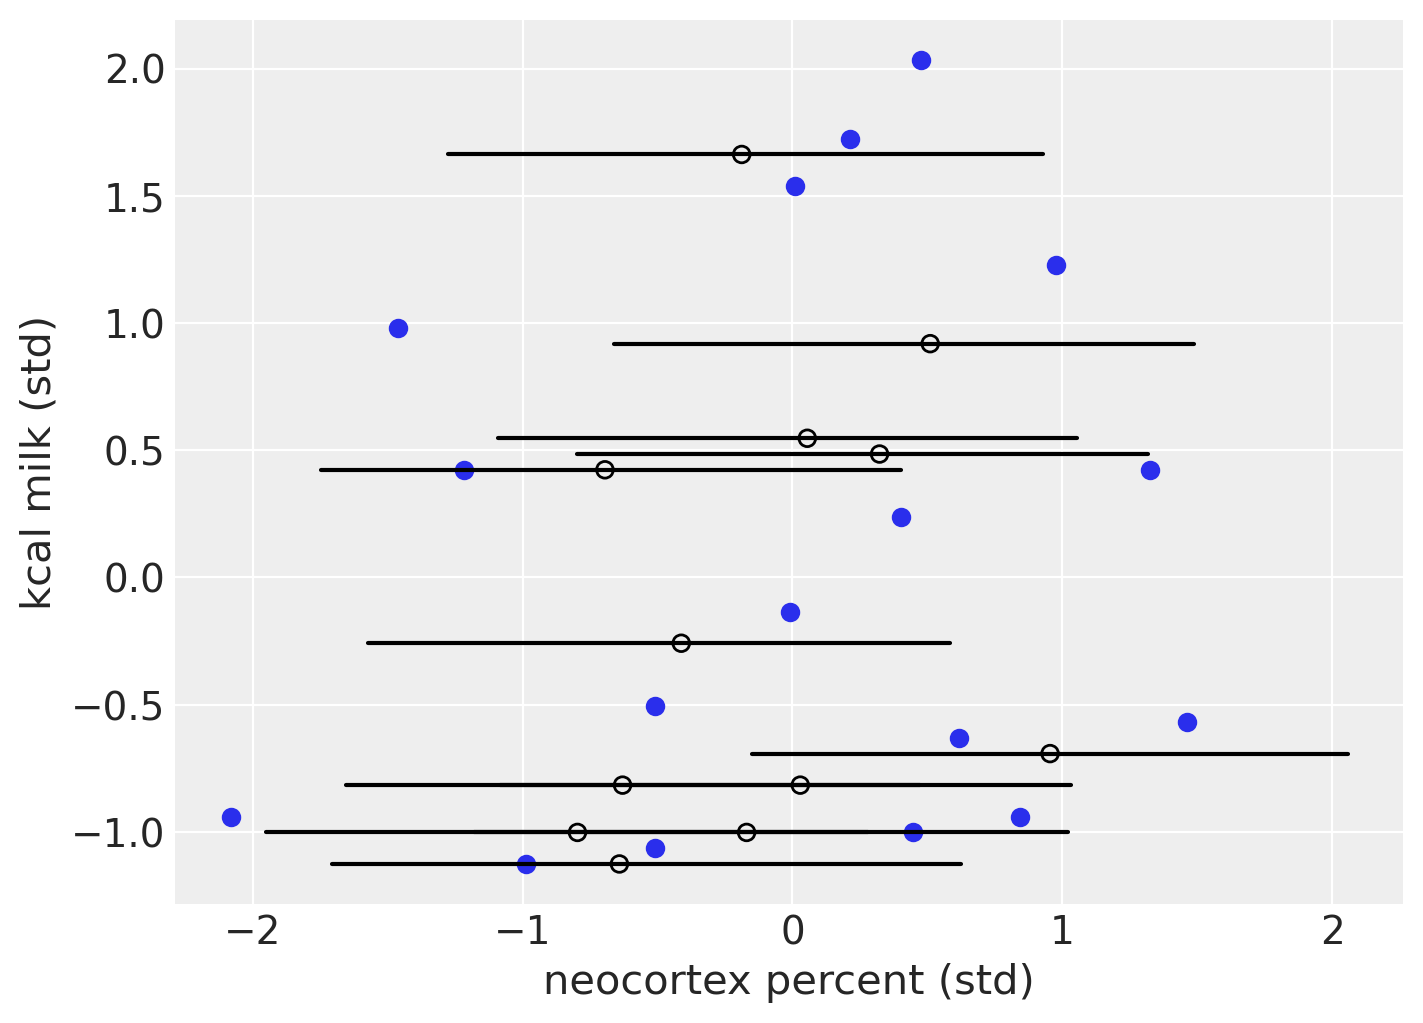

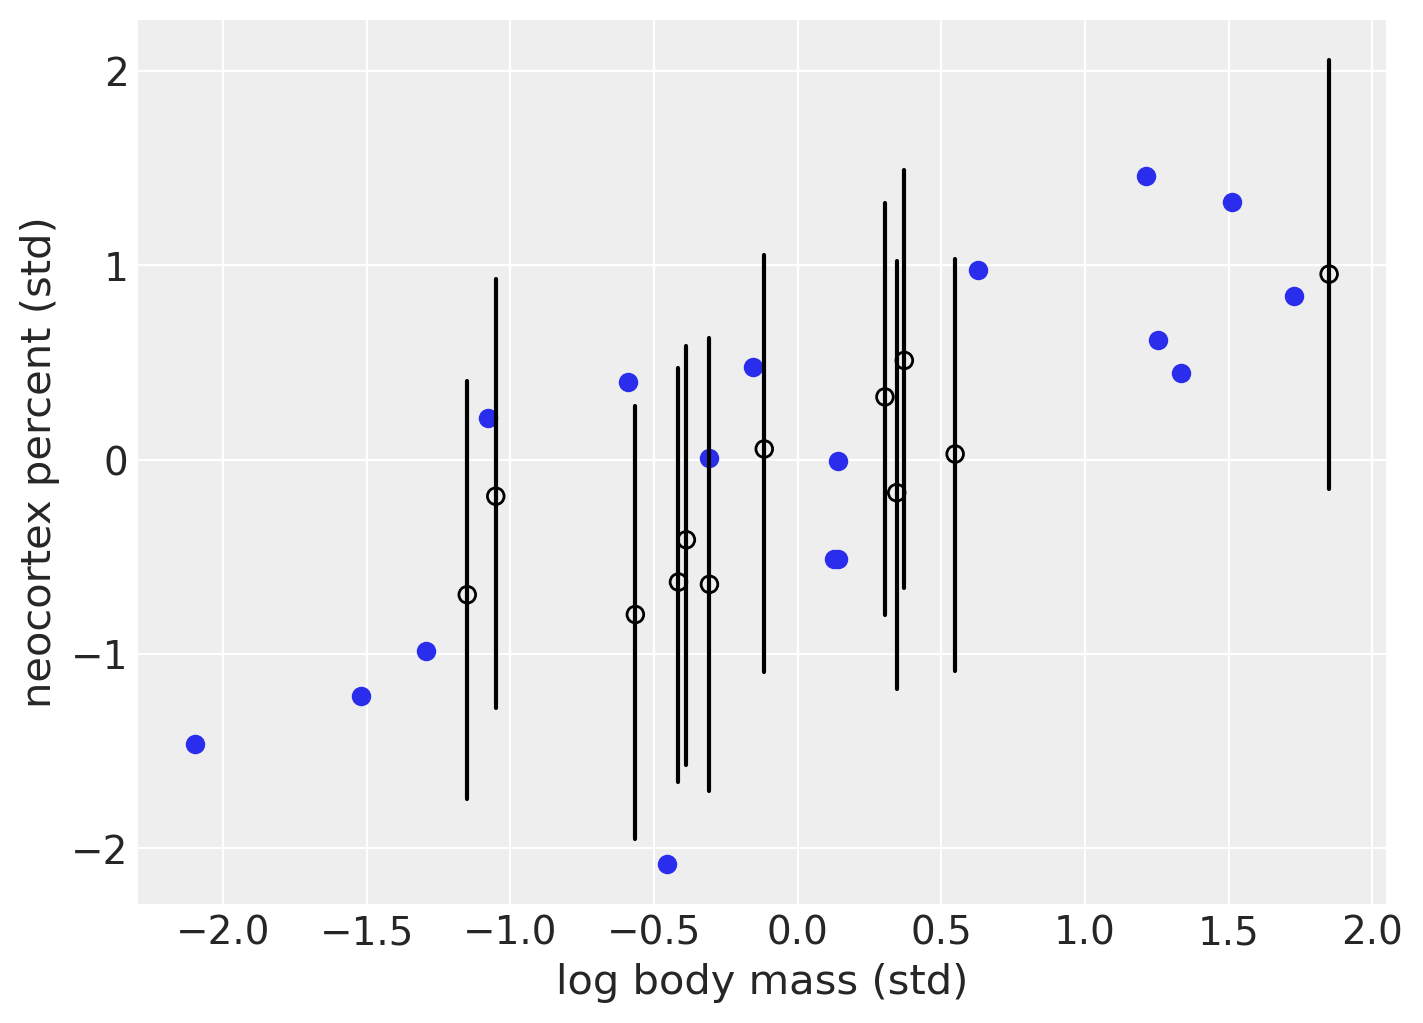

In [21]:
post = idata_m15_7.posterior

# Calculate the posterior mean and hdi for imputed values of B
B_impute_mu = post["MB_impute"].mean(dim=["chain", "draw"])
B_impute_ci = az.hdi(post, var_names=["MB_impute"])["MB_impute"]

# B vs K
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(B, K)
ax.scatter(B_impute_mu, K[~obs_idx], edgecolor="k", facecolor="none")
ax.plot(
    [B_impute_ci.sel(hdi="lower"), B_impute_ci.sel(hdi="higher")],
    [K[~obs_idx], K[~obs_idx]],
    color="k",
)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kcal milk (std)")

# M vs B
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(M, B)
ax.scatter(M[~obs_idx], B_impute_mu, edgecolor="k", facecolor="none")
ax.plot(
    [M[~obs_idx], M[~obs_idx]],
    [B_impute_ci.sel(hdi="lower"), B_impute_ci.sel(hdi="higher")],
    color="k",
)
ax.set_xlabel("log body mass (std)")
ax.set_ylabel("neocortex percent (std)");

#### Code 15.29

In [22]:
N_houses = 100  # Number of houses to simulate
alpha = 5  # Average number of notes when cat is absent
beta = -3  # Difference in number of notes when cat is present
k_true = 0.5  # Probability of cat present
r = 0.2  # Probability of not knowing whether cat present/absent

cat_true = rng.binomial(n=1, p=k_true, size=N_houses)
notes = rng.poisson(lam=alpha + beta * cat_true, size=N_houses)
R_C = rng.binomial(n=1, p=r, size=N_houses)
cat = cat_true.copy()
cat[R_C == 1] = -9

#### Code 15.30

In [23]:
with pm.Model() as m15_8:
    # priors
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 0.5)
    k = pm.Beta("k", 2, 2)

    # cat NA
    custom_logp = pm.math.logsumexp(
        pm.math.log(k)
        + pm.logp(pm.Poisson.dist(pm.math.exp(a + b)), notes[cat == -9])
        + pm.math.log(1 - k)
        + pm.logp(pm.Poisson.dist(pm.math.exp(a)), notes[cat == -9])
    )
    # Using pm.Potential to add custom term to model logp
    notes_RC_1 = pm.Potential("notes|RC==1", custom_logp)

    # cat known present/absent
    cat_RC_0 = pm.Bernoulli("cat|RC==0", k, observed=cat[cat != -9])
    lam = pm.math.exp(a + b * cat_RC_0)
    notes_RC_0 = pm.Poisson("notes|RC==0", lam, observed=notes[cat != -9])

    idata_m15_8 = pm.sample(random_seed=RANDOM_SEED)
az.summary(idata_m15_8, var_names=["a", "b", "k"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 158 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.55,0.07,1.44,1.65,0.0,0.0,3620.83,3034.55,1.0
b,-1.06,0.14,-1.29,-0.83,0.0,0.0,3522.53,2977.00,1.0
k,0.43,0.05,0.34,0.50,0.0,0.0,5228.44,2897.84,1.0


In [24]:
print(f"a from data generating process = {round(np.log(alpha), 2)}")
print(f"b from data generating process = {round(np.log(alpha+beta)-np.log(alpha), 2)}")
print(f"k from data generating process = {k_true}")

a from data generating process = 1.61
b from data generating process = -0.92
k from data generating process = 0.5


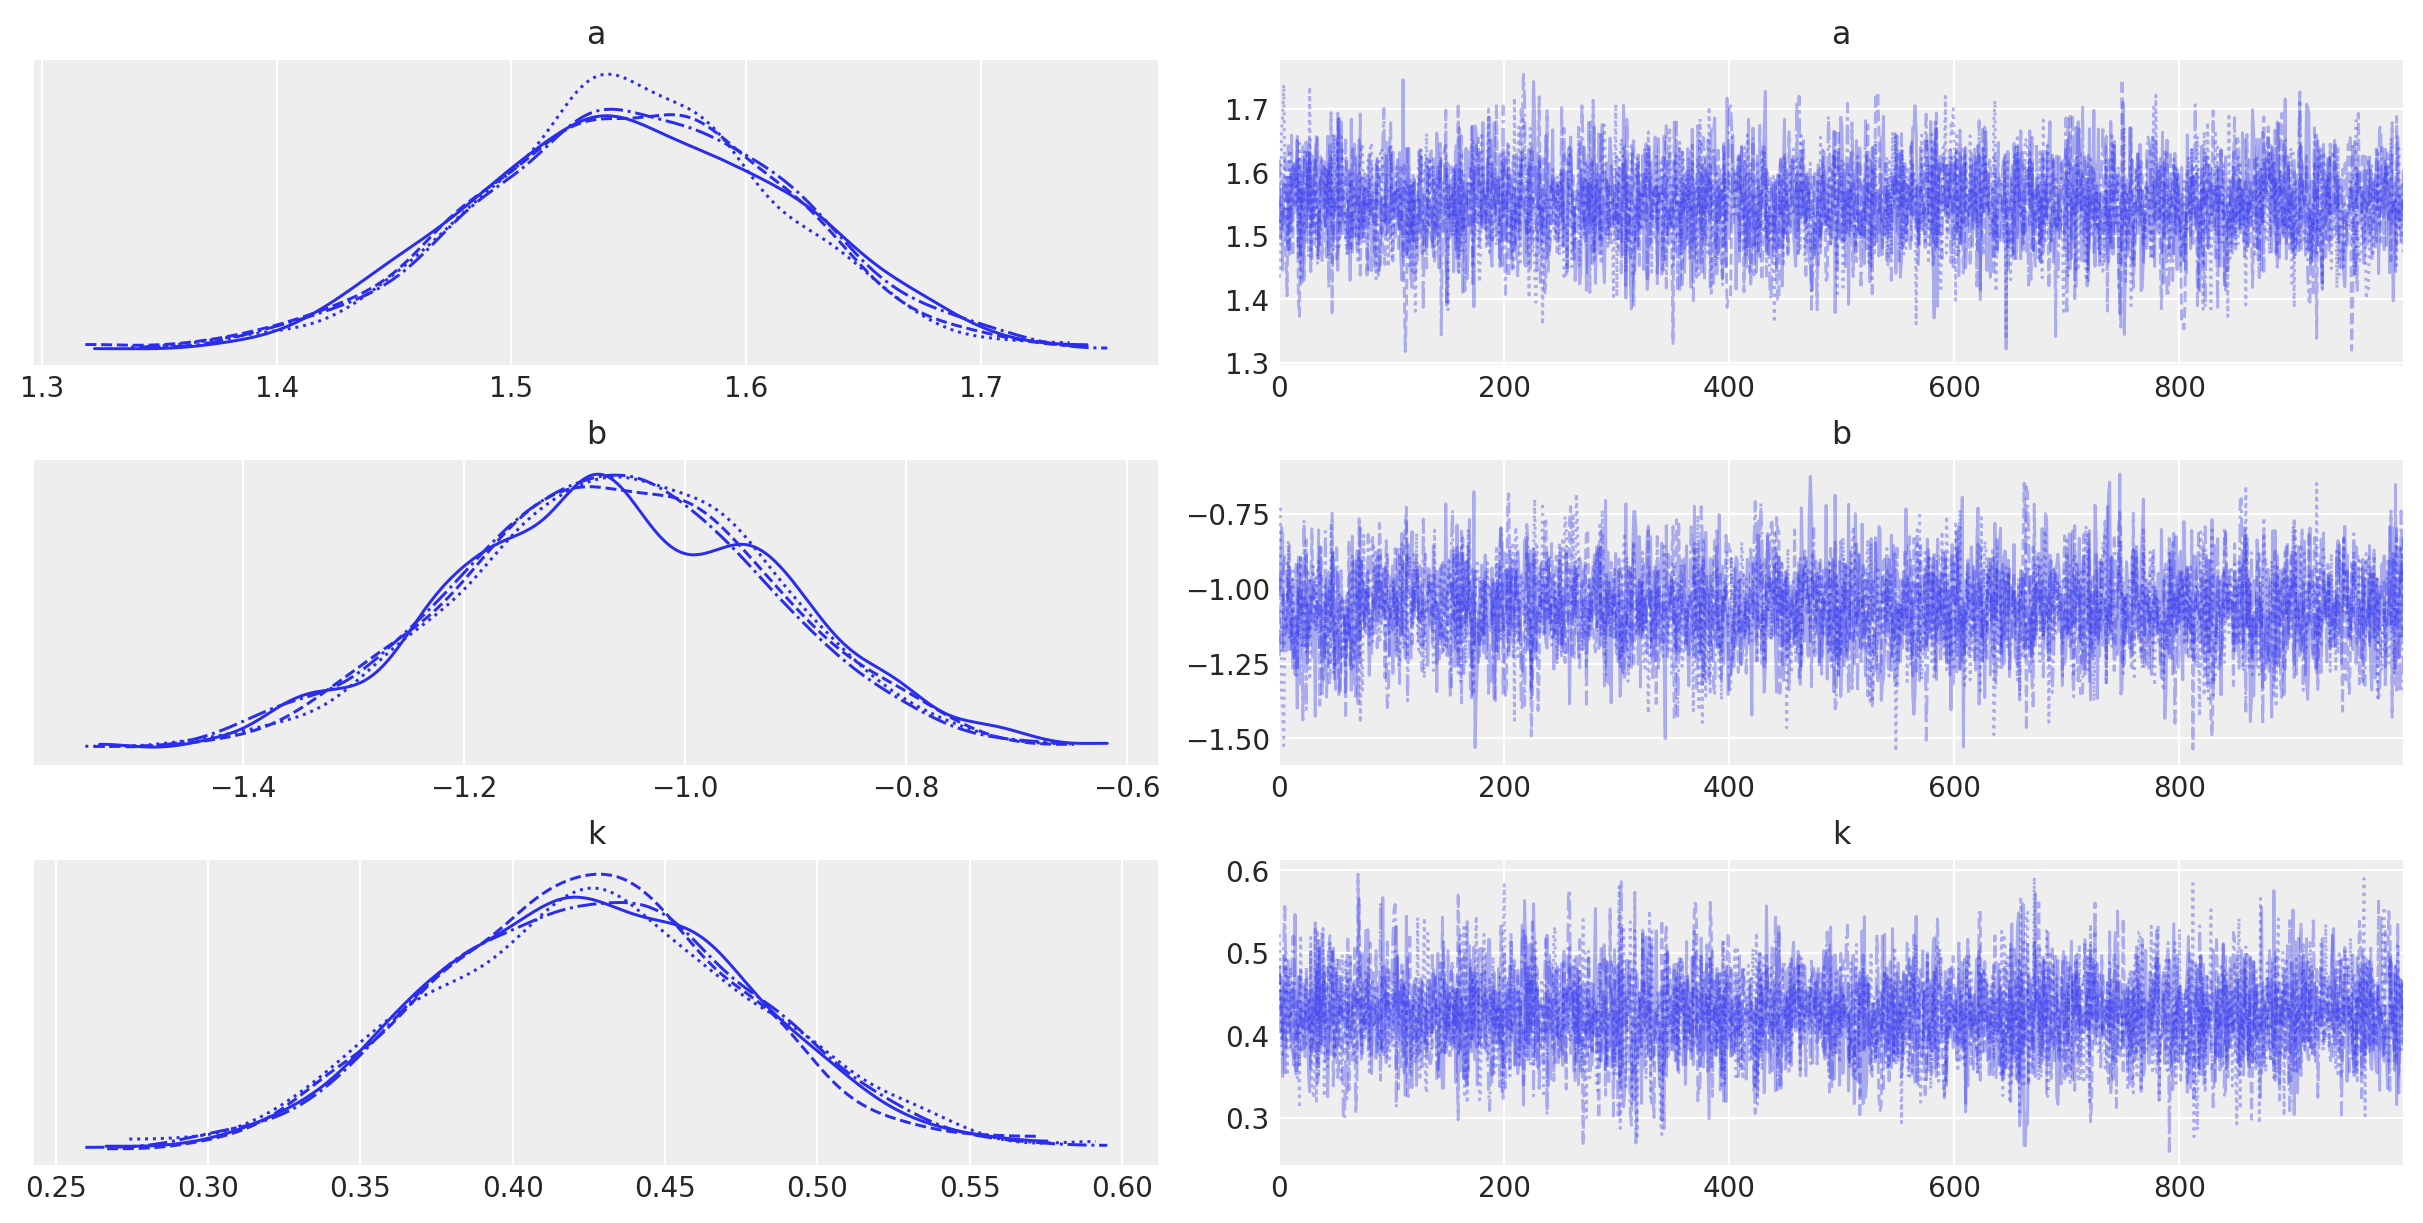

In [25]:
az.plot_trace(idata_m15_8, var_names=["a", "b", "k"]);

#### Code 15.31

In [26]:
with pm.Model() as m15_9:
    # priors
    a = pm.Normal("a", 0, 1)
    b = pm.Normal("b", 0, 0.5)
    k = pm.Beta("k", 2, 2)

    # cat NA
    custom_logp = pm.math.logsumexp(
        pm.math.log(k)
        + pm.logp(pm.Poisson.dist(pm.math.exp(a + b)), notes[cat == -9])
        + pm.math.log(1 - k)
        + pm.logp(pm.Poisson.dist(pm.math.exp(a)), notes[cat == -9])
    )
    notes_RC_1 = pm.Potential("notes|RC==1", custom_logp)

    # cat known present/absent
    cat_RC_0 = pm.Bernoulli("cat|RC==0", k, observed=cat[cat != -9])
    lam = pm.math.exp(a + b * cat_RC_0)
    notes_RC_0 = pm.Poisson("notes|RC==0", lam, observed=notes[cat != -9])

    # imputed values
    lpC0 = pm.Deterministic(
        "lpC0", pm.math.log(1 - k) + pm.logp(pm.Poisson.dist(pm.math.exp(a)), notes)
    )
    lpC1 = pm.Deterministic(
        "lpC1", pm.math.log(k) + pm.logp(pm.Poisson.dist(pm.math.exp(a + b)), notes)
    )
    PrC1 = pm.Deterministic("PrC1", pm.math.exp(lpC1) / (pm.math.exp(lpC1) + pm.math.exp(lpC0)))

    idata_m15_9 = pm.sample(random_seed=RANDOM_SEED)
az.summary(idata_m15_9, var_names=["a", "b", "k"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 489 seconds.


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.55,0.07,1.44,1.65,0.0,0.0,3620.83,3034.55,1.0
b,-1.06,0.14,-1.29,-0.83,0.0,0.0,3522.53,2977.00,1.0
k,0.43,0.05,0.34,0.50,0.0,0.0,5228.44,2897.84,1.0


In [27]:
# Posterior P(C==1|N)
PrC1_hdi = az.hdi(idata_m15_9.posterior["PrC1"])["PrC1"]

# For display purposes, sort by whether the cat was absent or present
sorted_cats = np.argsort(cat_true)
cat_true_sorted = cat_true[sorted_cats]
PrC1_hdi_sorted = PrC1_hdi[sorted_cats]
cat_obs_sorted = cat[sorted_cats]

# We will give a different colour to cases where we don't know if the cat is there
cat_obs_sorted[cat_obs_sorted == -9] = 2

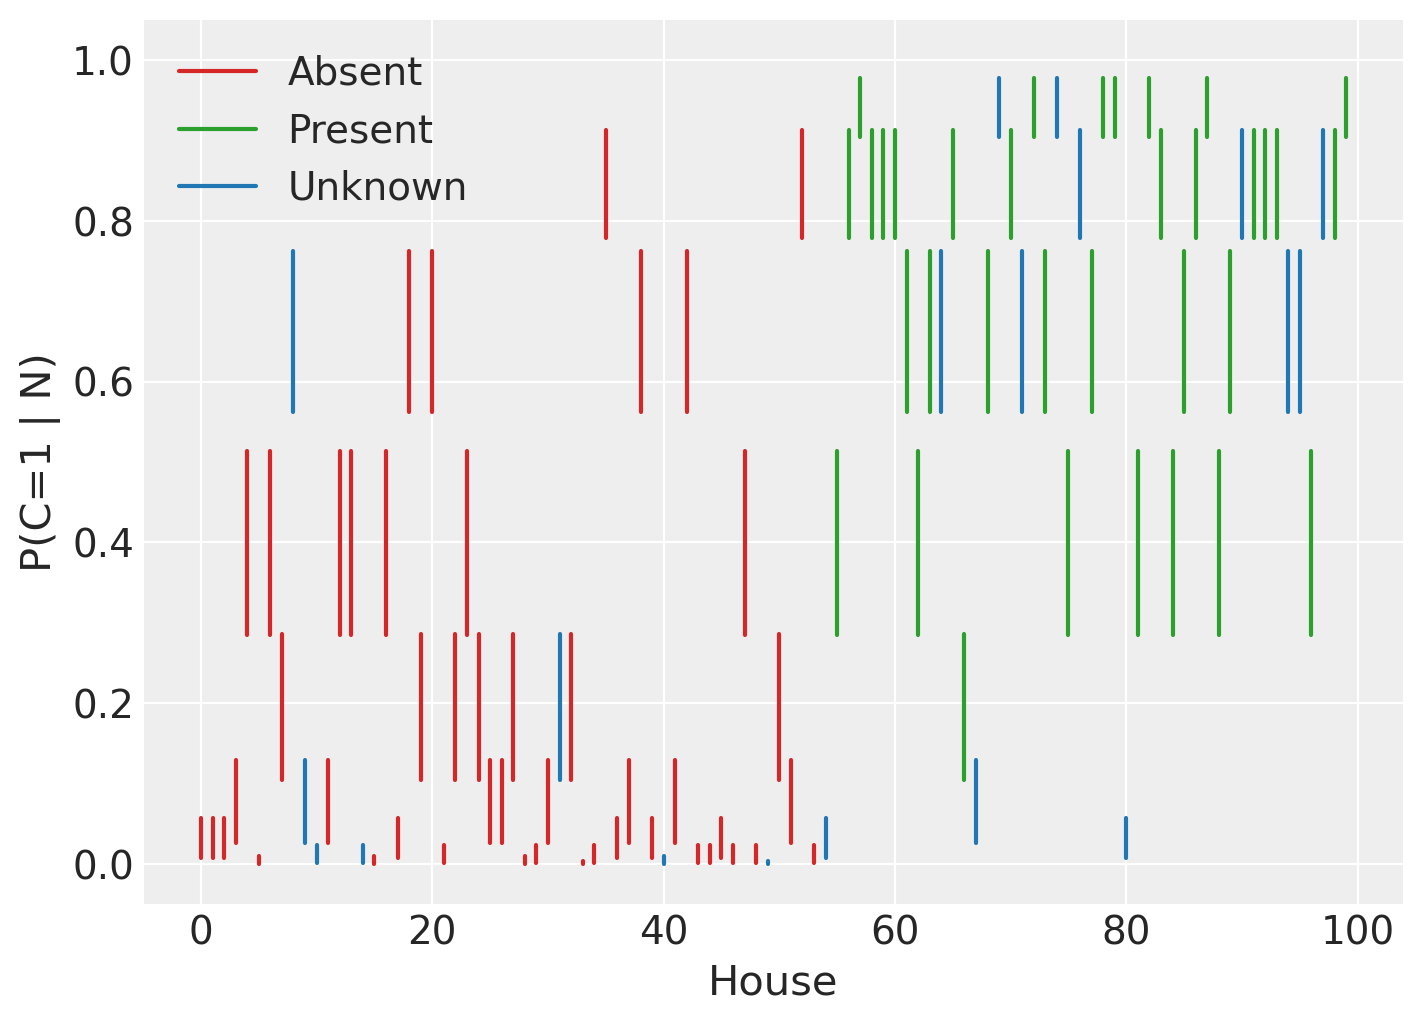

In [28]:
# Plot P(C==1 | N) for each house

labels = ["Absent", "Present", "Unknown"]
colours = ["tab:red", "tab:green", "tab:blue"]

fig, ax = plt.subplots(figsize=(7, 5))
for i in range(3):
    idx = cat_obs_sorted == i
    ax.plot(
        [np.flatnonzero(idx), np.flatnonzero(idx)],
        [PrC1_hdi_sorted[idx, 0], PrC1_hdi_sorted[idx, 1]],
        color=colours[i],
    )
    # Trick to have one label per group
    ax.axhline(2, color=colours[i], alpha=1, label=labels[i])

ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("House")
ax.set_ylabel("P(C=1 | N)")
ax.legend();

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Jan 06 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

arviz     : 0.17.0
pytensor  : 2.18.4
pymc      : 5.10.3
numpy     : 1.26.3
pandas    : 2.1.4
matplotlib: 3.8.2

Watermark: 2.4.3

